In [1]:
import import_parent

In [2]:
import tree_sim
# These constants are different from the values used in the paper.
# The paper uses EXPIRATION_TIME=1e3 and MEMORIES_PER_END_NODE=10
# For this demo, we used a smaller EXPIRATION_TIME to make the simulation react to changes in p faster
# The smaller EXPIRATION_TIME results in a lower success rate, so MEMORIES_PER_END_NODE was increased to compensate

tree_sim.EXPIRATION_TIME = 1e2 # we use 1e3 in the paper but that makes the sim take way too long to play with in a notebook.
tree_sim.MEMORIES_PER_END_NODE=50 # recommended "sane" range is 20 to 100.  (10 was used in the paper, but a shorter EXPIRATION_TIME requires more memory to compensate)

In [3]:
import draw_trees

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import plot_sim_results

In [6]:
import ipywidgets

In [7]:
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import colormaps
import numpy as np
from shutil import rmtree
import os
import pickle
from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm as tqdm
%matplotlib widget
matplotlib.rcParams['toolbar'] = 'None'
plasma = colormaps["plasma"]
viridis = colormaps["viridis"]

In [8]:
init_data = {
    "p" : 1e-2,
    "k" : 4,
    "n" : 3,
    "b" : 1
}
sim = tree_sim.TreeSim(p=init_data["p"], k=init_data["k"], n=init_data["n"], t=np.inf, b=init_data["b"])

In [9]:
def run_sim_with_size(n, k, b, samples):
    dir_str = f"jupyter_example_data/animation_{n}_{k}_{b}_{int(tree_sim.EXPIRATION_TIME)}_{tree_sim.MEMORIES_PER_END_NODE}"
    if not os.path.exists(dir_str):   
        os.makedirs(dir_str)
        pool = Pool()
        l=cpu_count()
        
        params = [{"p" : 0.1**(1+2*i/(l-1)), "k" : k, "n" : n, "t" : "2e3", "b" : b, "resample" : samples} for i in range(l)]
        for result in tqdm(pool.imap_unordered(tree_sim.launch_sim_from_dict, params), total=l):
            os.makedirs(os.path.join(dir_str, f"n_{result['init_data'][2]}"), exist_ok=True) # The data is organized into subfolders based on the value of n.
            with open(os.path.join(dir_str, f"n_{result['init_data'][2]}/{result['init_data']}.data"), "wb") as f: # Each individual simulation has a data file, with a name based on its parameters.
                pickle.dump(result, f)

    plotdict = {
            "x" : "p",
            "y" : "rate",
            "indir" : dir_str,
            "legend" : True,
            }
    plot_sim_results.make_plot_from_dict(plotdict)

In [10]:
def tuple_from_str(tupstr):
    a, b = tupstr.split("_")
    return (int(a), int(b))

def requests_with_node(node, sim):
    count = 0
    for request in sim.request_queue:
        if node[1] in request:
            count += 1
    return count

def entanglements_on_edge(edge, sim):
    return len(sim.entages[edge])

def max_mem_for_edge(edge):
    return tree_sim.MEMORIES_PER_END_NODE * (init_data["k"] ** (init_data["n"] - edge[0][0] - 1))

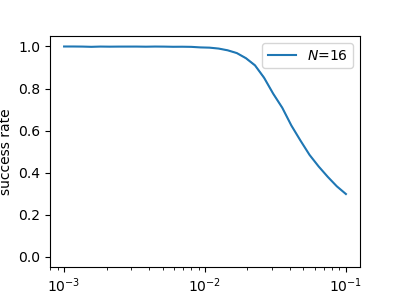

interactive(children=(Play(value=0, description='frame', interval=20, max=1000000), FloatLogSlider(value=0.02,…

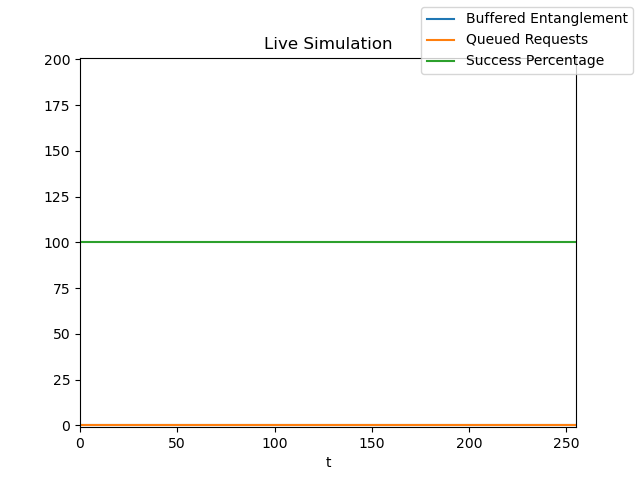

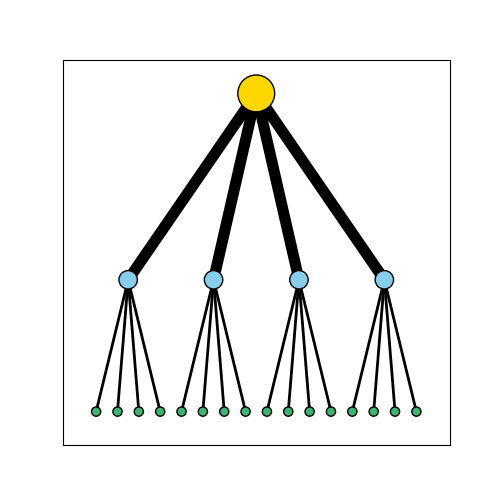

In [12]:
run_sim_with_size(init_data["n"],init_data["k"],init_data["b"],10)
vline = plt.axvline(0.02)
_ = plt.title("Sweep over values of $p$")

fig = plt.Figure()
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas_footer_visible = False

datalength = 256
success_averaging_bins=16
memory_record = [0] * datalength
request_queue = [0] * datalength
latency_stats = [0] * datalength
latency_smooth = [0] * datalength
success_stats = [100] * datalength
success_smooth = [100] * datalength
last_success_data = [0,0]

x_axis = list(range(datalength))
last_frame = [0]

fig, ax = plt.subplots()
memline, = ax.plot(x_axis, memory_record, label='Buffered Entanglement')
reqline, = ax.plot(x_axis, request_queue, label='Queued Requests')
success, = ax.plot(x_axis, success_stats, label='Success Percentage')
#ageline, = ax.plot(x_axis, latency_smooth, label='Request Latency')
ax.set(xlim=(x_axis[0], x_axis[-1]), ylim=(-1,201), title="Live Simulation", xlabel="t")

fig.legend()


tree_nodes, tree_edges, tree_fig, tree_data = draw_trees.make_plot(draw_trees.gen_tree(init_data["k"], init_data["n"], layout_style="side", draw_routers=False, minedge=2, minnode=11), size=5)
tree_tups = [tuple_from_str(nodestr) for nodestr in tree_data["nodelist"]]
tree_pairs = [(tuple_from_str(edge[1]), tuple_from_str(edge[0])) for edge in tree_data["edgelist"]]

# these values were chosen experimentally to produce nice-looking results when graphed
per_node_max_req = 20
edge_saturation_expectation = 0.2

def animate(frame, p):
    vline.set_xdata([p,p])
    if frame != last_frame[0]:
        last_frame[0] = frame
    else:
        return
    sim.p = p
    sim.time_cycle()
    d_sat = sim.requests_satisfied - last_success_data[0]
    d_exp = sim.requests_expired - last_success_data[1]
    
    request_count = sim.requests_enqueued - last_success_data[0] - last_success_data[1]
    # request_count = len(sim.request_queue) # this method doesn't show requests that get completed immediately
    last_success_data[0] = sim.requests_satisfied
    last_success_data[1] = sim.requests_expired
    success_rate = success_stats[-1]
    if d_sat + d_exp > 0:
        success_rate = d_sat * 100 / (d_sat + d_exp)
    new_data = sim.entanglements_made - sim.entanglements_used - sim.entanglements_expired
    latency_stats.pop(0)
    if len(sim.requests_cycles) > 0:
        latency_stats.append(np.mean(sim.requests_cycles))
    else:
        latency_stats.append(latency_stats[-1])
    sim.requests_cycles = []
    
    memory_record.pop(0)
    memory_record.append(new_data)
    request_queue.pop(0)
    request_queue.append(request_count)
    success_stats.pop(0)
    success_stats.append(success_rate)
    success_smooth.pop(0)
    success_smooth.append(np.mean(success_stats[-success_averaging_bins:-1]))
    latency_smooth.pop(0)
    latency_smooth.append(np.mean(latency_stats[-success_averaging_bins:-1]))
    
    x_axis.pop(0)
    x_axis.append(x_axis[-1]+1)

    memline.set_data(x_axis, memory_record)
    reqline.set_data(x_axis, request_queue)
    success.set_data(x_axis, success_smooth)
    #ageline.set_data(x_axis, latency_smooth)
    ax.set(xlim=(x_axis[0], x_axis[-1]), ylim=(-1,201))

    new_node_colors = [plasma(requests_with_node(tree_tups[i], sim) / per_node_max_req) if tree_tups[i][0] == (init_data["n"] - 1) else "black" for i in range(len(tree_tups))]
    #new_node_colors = [cmap(requests_with_node(tree_tups[i], sim) / 20) if tree_tups[i][0] == (init_data["n"] - 1) else tree_data["nodecolor"][i] for i in range(len(tree_tups))]
    tree_nodes.set_facecolors(new_node_colors)

    new_edge_colors = [viridis(entanglements_on_edge(tree_pairs[i], sim) / (max_mem_for_edge(tree_pairs[i]) * edge_saturation_expectation)) for i in range(len(tree_pairs))]
    tree_edges.set_colors(new_edge_colors)
    #for edge in tree_pairs:
    #    eoe = entanglements_on_edge(edge, sim)
    #    mmfe = max_mem_for_edge(edge)
    #    print(f"{edge}: {eoe}/{mmfe} = {eoe/mmfe}")

    
play = ipywidgets.interactive(animate, frame=ipywidgets.Play(0, 0, 1e6, 1, interval=20), p=ipywidgets.FloatLogSlider(0.02, base=10, min=-3, max=-1, step=0.05))
play

Here you can run a simulation live and see how the entanglement buffer, request queue, and success percentage react to changes in $p$.  A prerendered average success rate for different values of $p$ is provided.  At steady state, when the average success rate is low, the request queue will be large and the entanglement buffer small, and visa versa when the average success rate is high.  The simulation will take some time to react to changes in $p$.  In particular, a short-lived burst in requests will not oversaturate the network because the large entanglement buffer will be used to complete the requests.  A sustained high request rate will ev